In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Lecture des Datasets

Le nom de la colonne est la date de révision de la série. L'index des lignes est la date correspondant à la valeur de la série.

In [32]:
tp_vintages = pd.read_excel('BDD TP Nowcasted.xlsx')
# Mettre la colonne "Date" en index
tp_vintages.set_index('Date', inplace=True)

# Formater les noms des colonnes pour ne garder que la date
tp_vintages.columns = pd.to_datetime(tp_vintages.columns).strftime('%Y-%m-%d')

In [33]:
tp_vintages.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 878 entries, 1949-10-01 to 2022-11-01
Columns: 112 entries, 2013-09-01 to 2022-12-01
dtypes: float64(111), int64(1)
memory usage: 775.1 KB


In [34]:
# Lire le fichier CSV
cli_vintages = pd.read_csv('pivot_cli_filtered.csv', sep=';')

# Remplacer les noms des colonnes par les valeurs de la première ligne
cli_vintages.columns = cli_vintages.iloc[0]

# Mettre 'TIME_PERIOD' en index
cli_vintages.set_index('TIME_PERIOD', inplace=True)

# Supprimer la première ligne qui est maintenant redondante
cli_vintages = cli_vintages.drop(cli_vintages.index[0])

# Convertir toutes les valeurs en float
cli_vintages = cli_vintages.apply(pd.to_numeric, errors='coerce')


In [35]:
# Convertir les index en datetime
tp_vintages.index = pd.to_datetime(tp_vintages.index)
cli_vintages.index = pd.to_datetime(cli_vintages.index)
tp_vintages.columns = pd.to_datetime(tp_vintages.columns)
cli_vintages.columns = pd.to_datetime(cli_vintages.columns)

# Renommer les index pour qu'ils aient le même nom
tp_vintages.index.name = 'TIME_PERIOD'
cli_vintages.index.name = 'TIME_PERIOD'


In [36]:
'''print("tp_vintages:")
display(tp_vintages)

print("cli_vintages:")
cli_vintages'''

'print("tp_vintages:")\ndisplay(tp_vintages)\n\nprint("cli_vintages:")\ncli_vintages'

## 2. Filtering

In [37]:
# Identifier les colonnes communes
common_columns = tp_vintages.columns.intersection(cli_vintages.columns)

# Filtrer les DataFrames pour ne conserver que les colonnes communes
tp_vintages_filtered = tp_vintages[common_columns]
cli_vintages_filtered = cli_vintages[common_columns]

# Identifier les lignes (index) communes
common_index = tp_vintages_filtered.index.intersection(cli_vintages_filtered.index)

# Filtrer les DataFrames pour ne conserver que les lignes communes
tp_vintages_filtered = tp_vintages_filtered.loc[common_index]
cli_vintages_filtered = cli_vintages_filtered.loc[common_index]

In [38]:
'''# Afficher les DataFrames filtrés
print("tp_vintages_filtered:")
display(tp_vintages_filtered)

print("\ncli_vintages_filtered:")
display(cli_vintages_filtered)'''

'# Afficher les DataFrames filtrés\nprint("tp_vintages_filtered:")\ndisplay(tp_vintages_filtered)\n\nprint("\ncli_vintages_filtered:")\ndisplay(cli_vintages_filtered)'

## 3. Modélisation

In [39]:
# Detect and interpolate outliers using a rolling Median Absolute Deviation
def remove_outliers_rolling_mad(series, window=12, threshold=3.5):
    s = series.copy()
    
    def rolling_mad(x):
        m = np.median(x)
        return np.median(np.abs(x - m))
    
    rolling_median = s.rolling(window=window, center=True).median()
    rolling_mad_series = s.rolling(window=window, center=True).apply(rolling_mad, raw=True)
    
    median_vals = rolling_median.values
    mad_vals = rolling_mad_series.values
    outlier_mask = np.zeros(len(s), dtype=bool)

    for i in range(len(s)):
        if not np.isnan(median_vals[i]) and not np.isnan(mad_vals[i]) and mad_vals[i] != 0:
            diff = abs(s.iloc[i] - median_vals[i])
            if diff > threshold * mad_vals[i]:
                outlier_mask[i] = True

    s[outlier_mask] = np.nan
    s = s.interpolate(method='linear', limit_direction='both')
    
    return s

In [40]:
# Single Bry-Boschan run to detect local peaks/troughs with constraints
def bry_boschan_once(series, min_phase=5, min_cycle=15):
    idx = series.index
    vals = series.values
    n = len(vals)

    potential = []
    for i in range(1, n - 1):
        if vals[i] > vals[i - 1] and vals[i] > vals[i + 1]:
            potential.append((i, 'peak'))
        elif vals[i] < vals[i - 1] and vals[i] < vals[i + 1]:
            potential.append((i, 'trough'))

    potential.sort(key=lambda x: x[0])
    refined = []

    for pt in potential:
        if not refined:
            refined.append(pt)
        else:
            pr_i, pr_tp = refined[-1]
            cu_i, cu_tp = pt

            if cu_tp == pr_tp:
                if pr_tp == 'peak':
                    if vals[cu_i] > vals[pr_i]:
                        refined[-1] = pt
                else:
                    if vals[cu_i] < vals[pr_i]:
                        refined[-1] = pt
            else:
                refined.append(pt)



    phase_f = []
    i = 0

    while i < len(refined):
        if not phase_f:
            phase_f.append(refined[i])
            i += 1
        else:
            p_i, p_tp = phase_f[-1]
            c_i, c_tp = refined[i]
            dist = c_i - p_i

            if dist < min_phase:
                if p_tp == 'peak':
                    if vals[c_i] > vals[p_i]:
                        phase_f[-1] = (c_i, c_tp)
                else:
                    if vals[c_i] < vals[p_i]:
                        phase_f[-1] = (c_i, c_tp)
                i += 1
            else:
                phase_f.append(refined[i])
                i += 1


    final = []
    j = 0

    while j < len(phase_f):
        if not final:
            final.append(phase_f[j])
            j += 1
        else:
            pr_i, pr_tp = final[-1]
            cu_i, cu_tp = phase_f[j]

            if cu_tp == pr_tp:
                dist2 = cu_i - pr_i
                if dist2 < min_cycle:
                    if pr_tp == 'peak':
                        if vals[cu_i] > vals[pr_i]:
                            final[-1] = (cu_i, cu_tp)
                    else:
                        if vals[cu_i] < vals[pr_i]:
                            final[-1] = (cu_i, cu_tp)
                    j += 1
                else:
                    final.append(phase_f[j])
                    j += 1
            else:
                final.append(phase_f[j])
                j += 1

    return [(idx[p], tp) for (p, tp) in final]

In [41]:
# Compute Phase Average Trend (PAT)
def compute_pat_trend(series, turning_points):
    n = len(series)
    idx = series.index
    vals = series.values

    if not turning_points:
        return pd.Series(np.full(n, np.mean(vals)), index=idx)

    turning_idx = [0]
    idx_map = {dt: i for i, dt in enumerate(idx)}

    for (dt, _) in turning_points:
        if dt in idx_map:
            turning_idx.append(idx_map[dt])

    if turning_idx[-1] != n - 1:  
        turning_idx.append(n - 1)

    turning_idx.sort()
    phase_means = []

    for k in range(len(turning_idx) - 1):
        s_i = turning_idx[k]
        e_i = turning_idx[k + 1]
        seg = vals[s_i:e_i + 1]
        pm = np.mean(seg)
        phase_means.append(pm)

    smooth_pm = []

    if len(phase_means) < 3:
        smooth_pm = phase_means
    else:
        for i in range(len(phase_means)):
            if i == 0:
                val = (phase_means[0] + phase_means[1]) / 2.0
            elif i == len(phase_means) - 1:
                val = (phase_means[i] + phase_means[i - 1]) / 2.0
            else:
                val = (phase_means[i - 1] + phase_means[i] + phase_means[i + 1]) / 3.0
            smooth_pm.append(val)

    pat_trend = np.zeros(n)

    for k in range(len(turning_idx) - 1):
        s_i = turning_idx[k]
        e_i = turning_idx[k + 1]
        pat_trend[s_i:e_i + 1] = smooth_pm[k]

    return pd.Series(pat_trend, index=idx)

In [42]:
# Merge or remove very short cycles iteratively
def prune_short_cycles(tps, cycle_series, min_length=9, min_amplitude=0.5, max_passes=5):
    if not tps:
        return tps

    idx_map = {dt: i for i, dt in enumerate(cycle_series.index)}

    def single_pass(tps_in):
        if len(tps_in) < 2:
            return tps_in, False

        out = []
        changed = False
        i = 0

        while i < len(tps_in):
            if not out:
                out.append(tps_in[i])
                i += 1
            else:
                prev_t, prev_tp = out[-1]
                curr_t, curr_tp = tps_in[i]
                dist = (curr_t.year - prev_t.year) * 12 + (curr_t.month - prev_t.month)

                amp_ok = True
                if min_amplitude is not None and prev_tp != curr_tp:
                    if (prev_t in idx_map) and (curr_t in idx_map):
                        i1 = idx_map[prev_t]
                        i2 = idx_map[curr_t]
                        c1 = cycle_series.iloc[i1]
                        c2 = cycle_series.iloc[i2]
                        amplitude = abs(c2 - c1)
                        if amplitude < min_amplitude:
                            amp_ok = False

                if dist < min_length or not amp_ok:
                    changed = True
                    i += 1
                else:
                    out.append(tps_in[i])
                    i += 1

        return out, changed

    current = tps[:]
    for _ in range(max_passes):
        new_tps, changed = single_pass(current)
        if not changed:
            return new_tps
        current = new_tps

    return current

In [43]:
# Iteratively compute turning points with PAT and prune short cycles
def detect_turning_points_pat(
    series,
    min_phase=5,
    min_cycle=18,
    max_iter=3,
    final_min_phase=9,
    final_min_amp=0.5,
    final_max_passes=10
):
    raw_vals = series.copy()
    old_tps = None
    final_tps = None

    for _ in range(max_iter):

        tps_raw = bry_boschan_once(raw_vals, min_phase=min_phase, min_cycle=min_cycle)
        pat_series = compute_pat_trend(raw_vals, tps_raw)
        cyc = raw_vals - pat_series
        tps_cyc = bry_boschan_once(cyc, min_phase=min_phase, min_cycle=min_cycle)

        if old_tps is not None:
            if len(tps_cyc) == len(old_tps):
                same_count = sum(1 for (a, b) in zip(tps_cyc, old_tps) if a == b)
                if same_count == len(tps_cyc):
                    final_tps = tps_cyc
                    break

        old_tps = tps_cyc
        final_tps = tps_cyc

    if not final_tps:
        final_tps = old_tps if old_tps else []

    cyc = raw_vals - compute_pat_trend(raw_vals, final_tps)

    final_tps = prune_short_cycles(
        tps=final_tps,
        cycle_series=cyc,
        min_length=final_min_phase,
        min_amplitude=final_min_amp,
        max_passes=final_max_passes
    )

    return final_tps

## 4. Data Loading

In [44]:
MIN_PHASE = 5
MIN_CYCLE = 18
MAX_ITER = 5
MAD_WINDOW = 12
MAD_THRESHOLD = 3.5
FINAL_MIN_PHASE = 9
FINAL_MIN_AMPLITUDE = 0.5
FINAL_MAX_PASSES = 5

vintages = cli_vintages_filtered.columns
results = {}

for c in vintages: # Faire une boucle : for colonne in tp_vintages_filtered
    sub = cli_vintages_filtered[c]
    if sub.empty:
        print(f"No data for {c}, skip.")
        continue

    s = sub.sort_index()
    s_clean = remove_outliers_rolling_mad(s, window=MAD_WINDOW, threshold=MAD_THRESHOLD)

    tps_final = detect_turning_points_pat(
        series=s_clean,
        min_phase=MIN_PHASE,
        min_cycle=MIN_CYCLE,
        max_iter=MAX_ITER,
        final_min_phase=FINAL_MIN_PHASE,
        final_min_amp=FINAL_MIN_AMPLITUDE,
        final_max_passes=FINAL_MAX_PASSES
    )

    results[c] = tps_final

    '''print(f"\n--- {c} ---")
    if tps_final:
        for (dt, tp) in tps_final:
            print(dt.strftime('%Y-%m'), tp)
    else:
        print("No turning points found.")'''

## 5. Mise en forme des résultats

In [45]:
# Créer un nouveau DataFrame avec le même index et les mêmes noms de colonnes
resultats = pd.DataFrame(index=tp_vintages_filtered.index, columns=tp_vintages_filtered.columns)
resultats.head(1)

,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
1970-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#Placement des résultats dans le dataframe 

for publish_date in resultats.columns:
    for time, tp in results[publish_date]:
        if tp == 'trough':
            resultats.loc[time, publish_date] = 1
        elif tp == 'peak':
            resultats.loc[time, publish_date] = 0       

In [47]:
# Remplissage du dataframe 

for publish_date in resultats.columns:
    valeur = 0  # Initialiser valeur à 0 pour chaque colonne
    for time in resultats.index:
        if pd.isna(resultats.loc[time, publish_date]):
            resultats.loc[time, publish_date] = valeur
        else:
            valeur = resultats.loc[time, publish_date]
    
            

In [48]:
#Mise en forme en dent de scie du datframe

for publish_date in resultats.columns[:-1]:
    assert len(resultats.loc[publish_date:, publish_date].value_counts()) == 1 
    resultats.loc[publish_date:, publish_date] = np.nan


## 6. Tests et analyse des résultats

In [49]:
assert tp_vintages_filtered.columns.equals(resultats.columns)

percentage_differences = {}
index_difference_counts = {}

for publish_date in resultats.columns :
    output = resultats.loc[:publish_date - pd.DateOffset(months=1), publish_date]
    target = tp_vintages_filtered.loc[:publish_date - pd.DateOffset(months=1), publish_date]
    # Comparez les deux séries
    differences = output != target

    # Calculez le pourcentage de différences
    percentage_diff = differences.sum() / len(differences) * 100

    # Stockez le résultat
    percentage_differences[publish_date] = percentage_diff

    # Compte le nombre de fois où chaque index a une différence
    differing_indices = output.index[differences]
    
    for idx in differing_indices:
        index_difference_counts[idx] = index_difference_counts.get(idx, 0) + 1

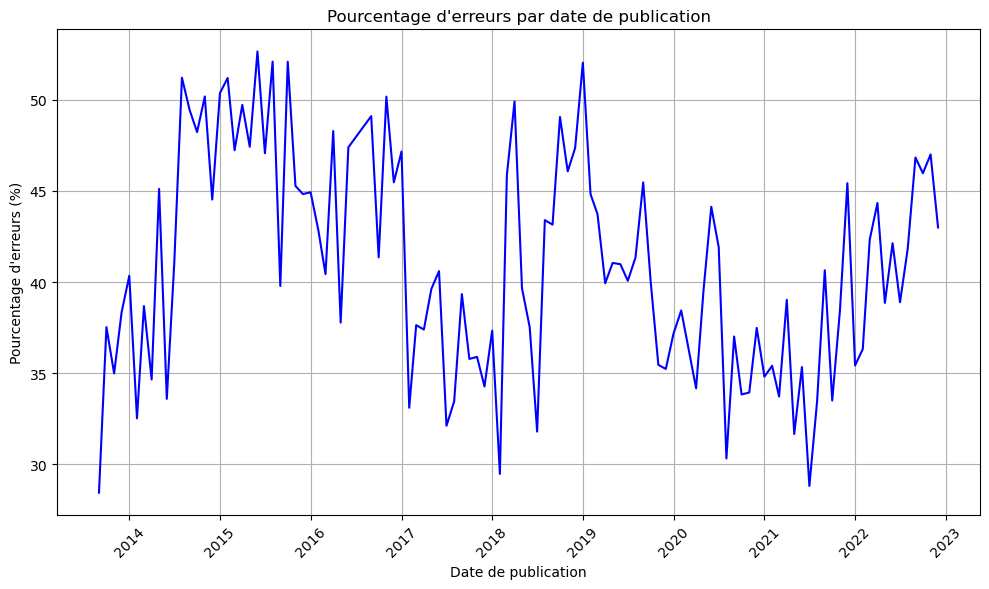

40.95723624125861


In [50]:
# Convertir les clés en objets datetime pour un meilleur affichage
dates = pd.to_datetime(list(percentage_differences.keys()))
percentages = list(percentage_differences.values())

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(dates, percentages, linestyle='-', color='b')
plt.title('Pourcentage d\'erreurs par date de publication')
plt.xlabel('Date de publication')
plt.ylabel('Pourcentage d\'erreurs (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()


mean_value = np.mean(list(percentage_differences.values()))
print(mean_value)

In [51]:
#Ca a l'air cohérent dans les chiffres
print(resultats.loc[:publish_date - pd.DateOffset(months=1), publish_date].tolist())
print(tp_vintages_filtered.loc[:publish_date - pd.DateOffset(months=1), publish_date].tolist())

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

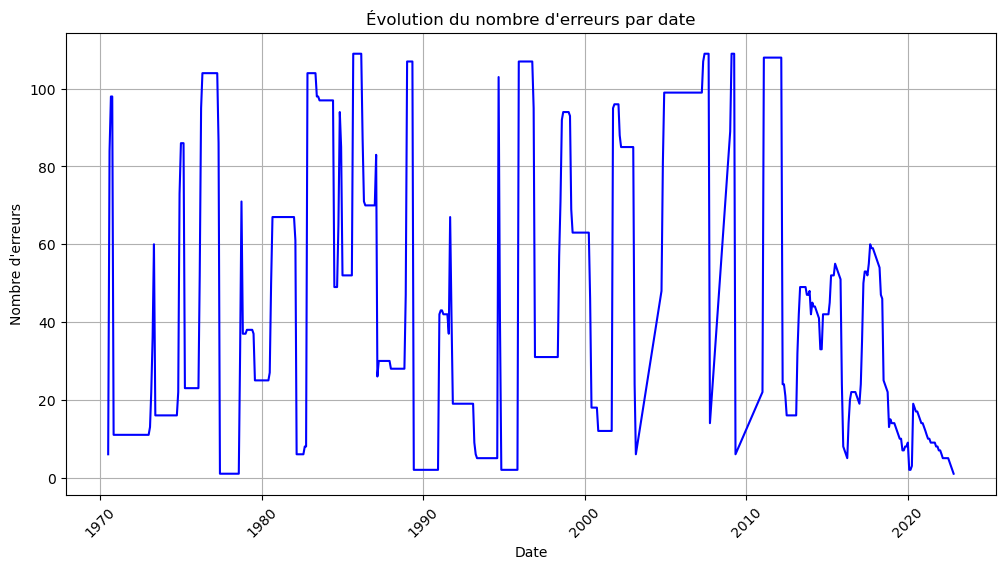

In [52]:
# Trier les dates dans l'ordre chronologique
sorted_dates = sorted(index_difference_counts.keys())
error_counts = [index_difference_counts[date] for date in sorted_dates]

# Tracer le graphique
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, error_counts, linestyle='-', color='b')

# Ajouter titres et labels
plt.xlabel("Date")
plt.ylabel("Nombre d'erreurs")
plt.title("Évolution du nombre d'erreurs par date")
plt.xticks(rotation=45)  # Rotation des labels en abscisse pour une meilleure lisibilité
plt.grid()

# Afficher le graphique
plt.show()

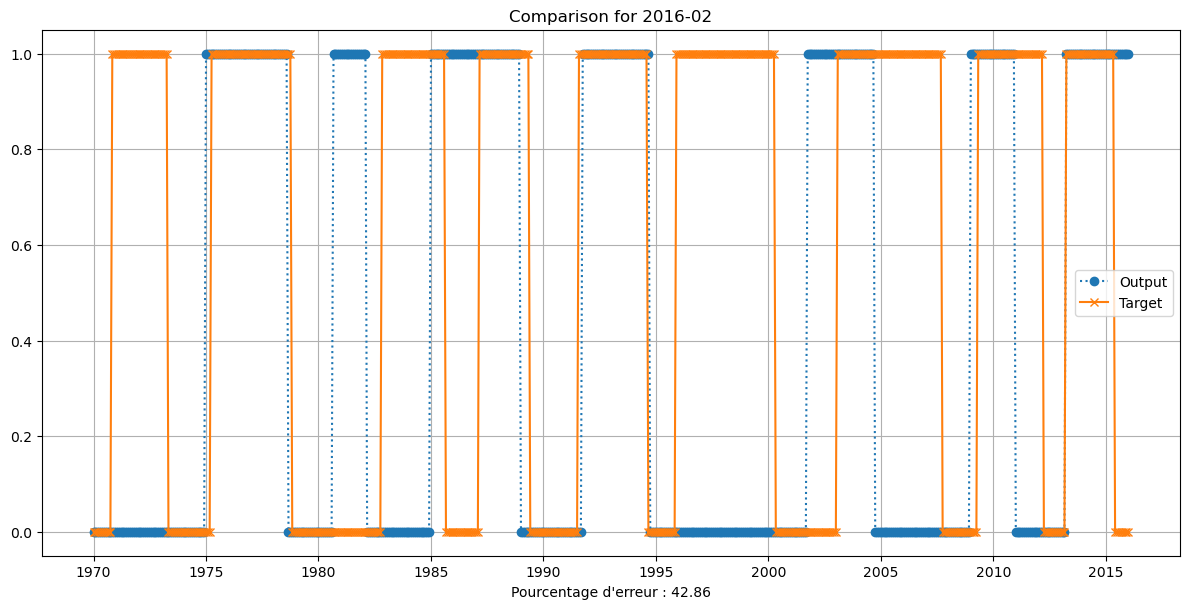

In [68]:
# Sélection aléatoire d'une seule colonne
random_column = np.random.choice(resultats.columns, size=1)[0]

# Création de la figure
plt.figure(figsize=(12, 6))  

# Extraction des données
output = resultats.loc[:random_column - pd.DateOffset(months=1), random_column]
target = tp_vintages_filtered.loc[:random_column - pd.DateOffset(months=1), random_column]

# Comparez les deux séries
differences = output != target

# Calculez le pourcentage de différences
percentage_diff = differences.sum() / len(differences) * 100
percentage_diff = round(percentage_diff, 2)

# Tracé des courbes
plt.plot(output.index, output.values, linestyle=':', marker='o', label="Output")
plt.plot(target.index, target.values, linestyle='-', marker='x', label="Target")

# Ajout des éléments de mise en page
plt.title(f"Comparison for {pd.Timestamp(random_column).strftime('%Y-%m')}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel(f"Pourcentage d'erreur : {percentage_diff}")



# Affichage du graphique
plt.show()
